<a href="https://colab.research.google.com/github/yasirabd/research-diagnostic-turbine/blob/main/Diagnostics_Turbine_Bearing_1_Cooling_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Create: 23 Desember 2021*<br>
*Last Update: 23 Desember 2021*<br>
*Author: Yasir Abdur Rohman*<br>
**Property of PT Indonesia Power & Lab Getaran & Diagnosis Mesin Undip**

---

## Problem Description

**Case:** ST Journal Bearing 1 - Cooling Loss

**Description:**

This fault indicates an abnormal change in the cooling of the supply oil to the bearings.  

Primary indicators are: 
- Journal Bearing Oil Outlet Temperature (Oil Return) is high; 
- and Bearing Metal Temperature is high.   

and 
- Priority 4 (lowest) is triggered when either Lube Oil Outlet Temperature is high or 
- Bearing Metal Temperature is high.  

The priority escalates depending on the severity of the change, and the number of sensors.  This fault triggers  Priority 2, 3 & 4.

**Input Tags:**
- LUBE_OIL_COOLER_OIL_OUTLET_TEMP
- GROSS_LOAD
- LUBE_OIL_COOLER_OIL_OUTLET_PRESS
- BRG_1_MTL_TEMP_1 
- AMBIENT_TEMP
- BRG_1_MTL_TEMP_2 
- BRG_1_MTL_TEMP_4 
- BRG_1_MTL_TEMP_3
- BRG_1_OIL_DRAIN_TEMP

**Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy.spatial import distance

from sklearn.metrics import mean_squared_error

# Dataset

In [ ]:
path = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01ags21-31okt21.csv"
data = pd.read_csv(path)
data.shape

(132479, 85)

In [ ]:
# slice data
cols = ['Generator Gross Capacity',
        'Turbine Lube Oil Cooler Outlet Temperature',
        'Turbine Bearing #01 Metal Temperature',
        'Turbine.Bearing 1 Metal Temperature',
        'Turbine.Bearing Oil Pressure',
        'Turbine.Bearing 1 Drain Oil Temperature']

data = data[['date']+cols]

# sort by index
data = data.sort_values(by='date').reset_index(drop=True)

# convert date to datetime
data['date'] = pd.to_datetime(data['date'])

data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine Bearing #01 Metal Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2021-08-01 00:00:00,594.655200,46.356762,79.52576,84.711440,1.288945,51.465816
1,2021-08-01 00:01:00,587.230042,46.344955,80.16380,84.924774,1.294842,51.453390
2,2021-08-01 00:02:00,590.609131,46.331780,80.53400,84.938736,1.290403,51.440964
3,2021-08-01 00:03:00,595.542969,46.318603,80.05665,84.700806,1.292539,51.428535
4,2021-08-01 00:04:00,595.711365,46.307793,79.51846,84.569700,1.293622,51.416110


In [ ]:
# handle missing with interpolation
for col in cols:
    data[col] = data[col].interpolate(method='linear')

data.isnull().sum()

date                                          0
Generator Gross Capacity                      0
Turbine Lube Oil Cooler Outlet Temperature    0
Turbine Bearing #01 Metal Temperature         0
Turbine.Bearing 1 Metal Temperature           0
Turbine.Bearing Oil Pressure                  0
Turbine.Bearing 1 Drain Oil Temperature       0
dtype: int64

# Prognostic (Estimate)

## Threshold

In [ ]:
# threshold
val = [[433.969025, 610.248900],
       [41.625633, 47.335740],
       [75.298727, 92.167030],
       [80.187670, 87.590470],
       [1.467023, 1.512295],
       [47.408993, 56.443672]]
threshold = pd.DataFrame(val, columns=['Actual (Low)', 'Actual (High)'], index=list(data)[1:])
threshold

,Actual (Low),Actual (High)
Generator Gross Capacity,433.969025,610.248900
Turbine Lube Oil Cooler Outlet Temperature,41.625633,47.335740
Turbine Bearing #01 Metal Temperature,75.298727,92.167030
Turbine.Bearing 1 Metal Temperature,80.187670,87.590470
Turbine.Bearing Oil Pressure,1.467023,1.512295
Turbine.Bearing 1 Drain Oil Temperature,47.408993,56.443672


## Infant Model

In [ ]:
# create an infant model
two_weeks = pd.to_datetime('2021-09-01 00:00:00') + pd.DateOffset(days=15)

# filter data by date
filter = (data['date'] >= '2021-09-01 00:00:00') & (data['date'] < two_weeks)
data_slice = data[filter].reset_index(drop=True)
data_slice.shape

(21600, 7)

In [ ]:
# create state_matrix for an infant model
state_matrix = []
for i in range(len(data_slice)):

    temp = []
    for col in cols:
        actual = data_slice.loc[i,col]
        th_low = threshold.loc[col, 'Actual (Low)']
        th_high = threshold.loc[col, 'Actual (High)']

        if actual > th_low and actual < th_high:
            temp.append(actual)
        else:
            break

    if len(temp) == 6:
        state_matrix.append(np.array(temp))
    
    if len(state_matrix) == 400:
        state_matrix = np.array(state_matrix).T
        print(i)
        break

411


In [ ]:
state_matrix.shape

(6, 400)

## VBM

In [ ]:
def scipy_distance(vector1, vector2, dist='euclidean'):
    if dist == 'euclidean':
        return distance.euclidean(vector1, vector2)
    elif dist == 'braycurtis':
        return distance.braycurtis(vector1, vector2)
    elif dist == 'correlation':
        return distance.correlation(vector1, vector2)
    elif dist == 'canberra':
        return distance.canberra(vector1, vector2)
    elif dist == 'chebyshev':
        return distance.chebyshev(vector1, vector2)
    elif dist == 'cityblock':
        return distance.cityblock(vector1, vector2)
    elif dist == 'minkowski':
        return distance.minkowski(vector1, vector2)
    elif dist == 'sqeuclidean':
        return distance.sqeuclidean(vector1, vector2)
    elif dist == 'cosine':
        return distance.cosine(vector1, vector2)

# function to create a dynamic matrix 
def create_dynamic_matrix(matrix, current_actual):
    
    # get current actual
    # current_actual = matrix[:, -1]

    # calculate similarity
    sim_vec = []
    for i in range(matrix.shape[1]):
        sim = 1 - scipy_distance(current_actual, matrix[:, i], dist='canberra')
        sim_vec.append(sim)
    
    # sort the matrix
    n = 10
    top = np.sort(np.array(sim_vec).argsort()[::-1][:n])
    top_sim_vec = np.array(sim_vec)[top]

    # create dynamic matrix
    dynamic_matrix = matrix[:, top]

    # calculate weight
    weight = np.array([s/np.sum(top_sim_vec) for s in top_sim_vec])

    return dynamic_matrix, weight

def vbm(dynamic_matrix, weight):
    return np.dot(dynamic_matrix, weight.T)

# Diagnostic

## Analytic Tag Attributes

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

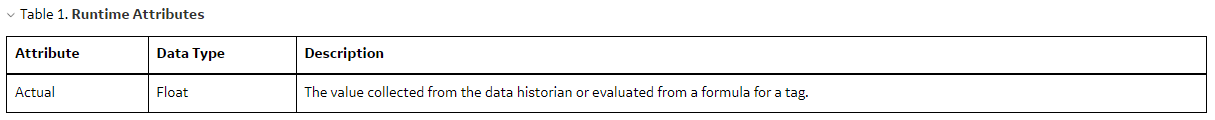

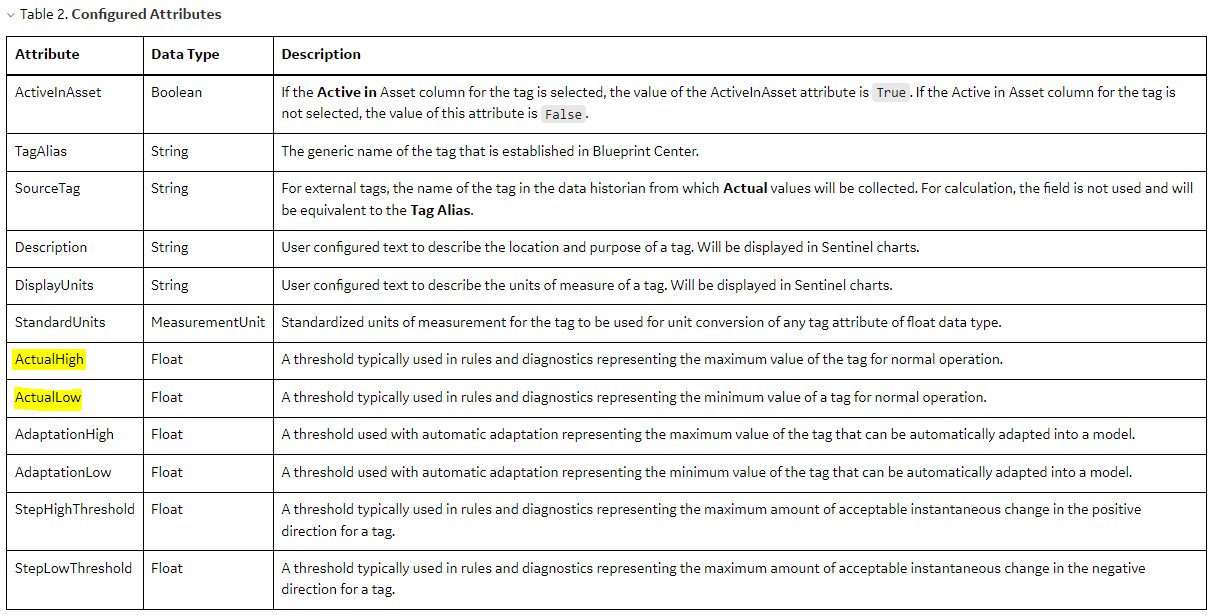

## Model Tag Attributes

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

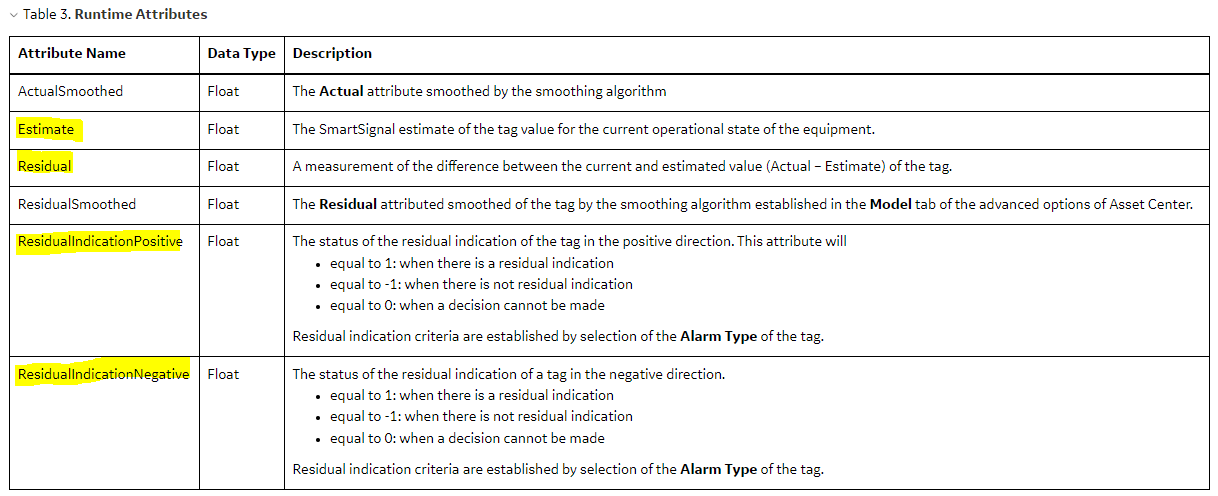

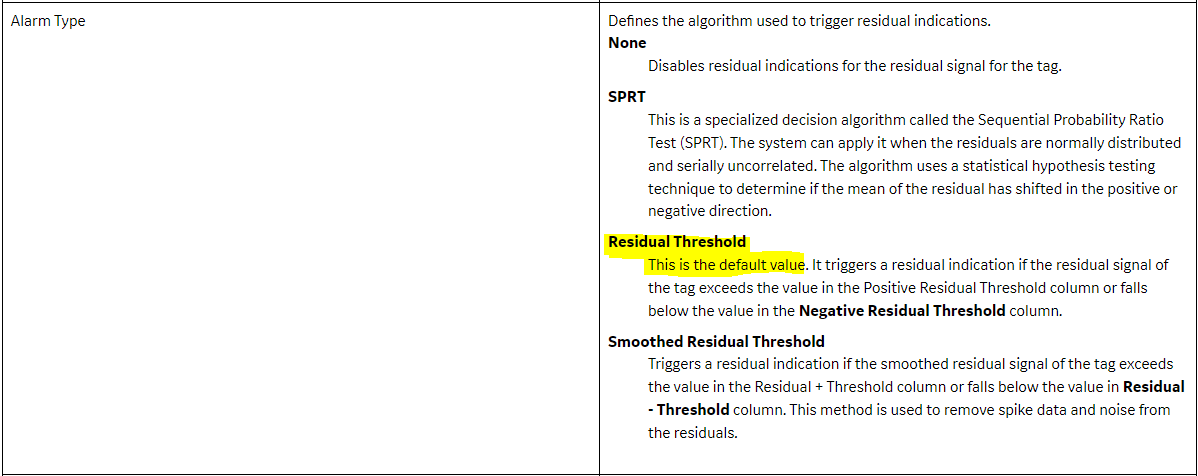

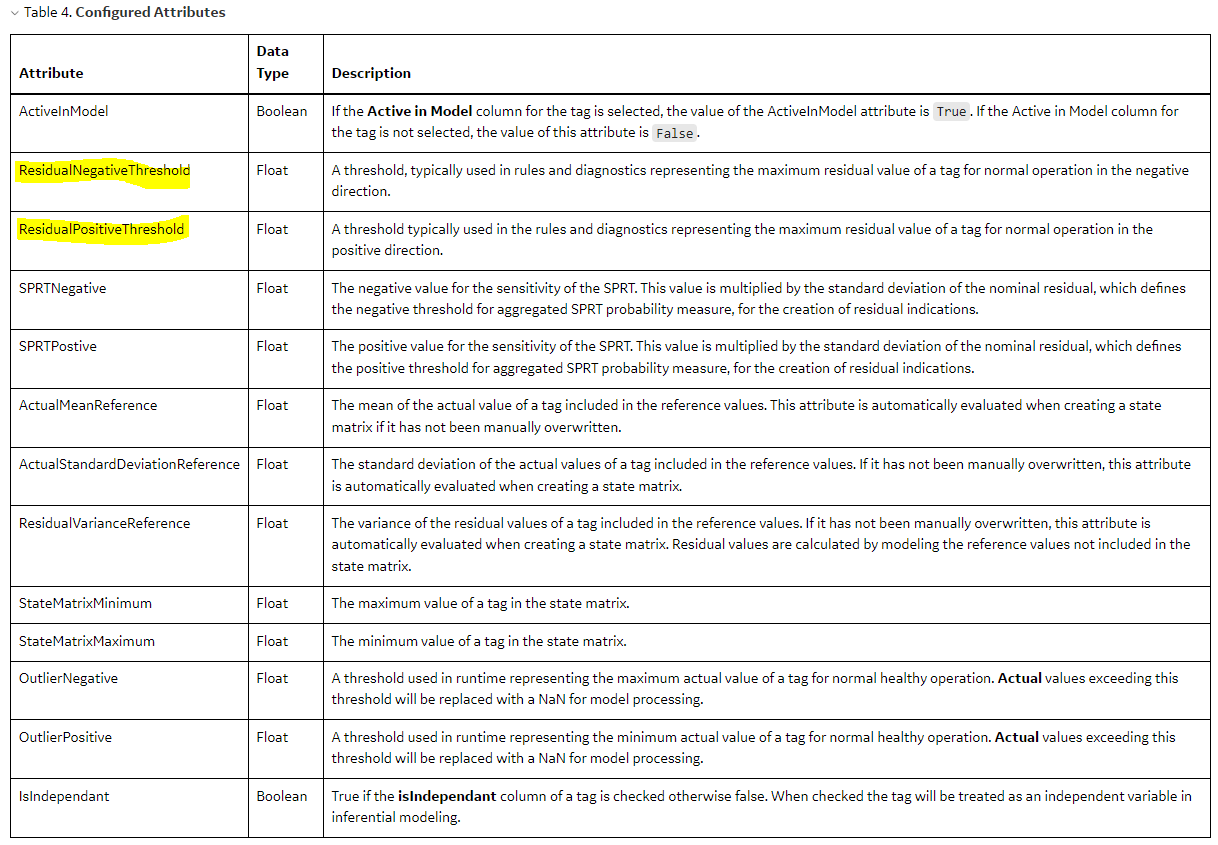

Analytic tag attributes needed for `ST Journal Bearing 1 - Cooling Loss`.

Runtime Attributes:
- `Actual`

Configured Attributes:
- `ActualHigh`
- `ActualLow`

Model tag attributes needed for `ST Journal Bearing 1 - Cooling Loss`.

Runtime Attributes:
- `Estimate`
- `Residual`
- `ResidualIndicationPositive`
- `ResidualIndicationNegative`

Configured Attributes:
- `ResidualNegativeThreshold`
- `ResidualPositiveThreshold`

> We choose `AlarmType` by default is `Residual Threshold`

We need to define all of the **Configured Attributes**.

## Define Configured Attributes

In [ ]:
# analytic tag
analytic_configured = threshold.copy()
# rename columns name
analytic_configured = analytic_configured.rename(columns={'Actual (Low)':'ActualLow',
                                                          'Actual (High)':'ActualHigh'})
analytic_configured

,ActualLow,ActualHigh
Generator Gross Capacity,433.969025,610.248900
Turbine Lube Oil Cooler Outlet Temperature,41.625633,47.335740
Turbine Bearing #01 Metal Temperature,75.298727,92.167030
Turbine.Bearing 1 Metal Temperature,80.187670,87.590470
Turbine.Bearing Oil Pressure,1.467023,1.512295
Turbine.Bearing 1 Drain Oil Temperature,47.408993,56.443672


In [ ]:
analytic_configured['ActualHigh'] - analytic_configured['ActualLow']

Generator Gross Capacity                      176.279875
Turbine Lube Oil Cooler Outlet Temperature      5.710107
Turbine Bearing #01 Metal Temperature          16.868303
Turbine.Bearing 1 Metal Temperature             7.402800
Turbine.Bearing Oil Pressure                    0.045272
Turbine.Bearing 1 Drain Oil Temperature         9.034679
dtype: float64

In [ ]:
# model tag

# use the difference between ActualHigh and ActualLow
values = [[-176.279875, 176.279875],
          [-5.710107, 5.710107],
          [-16.868303, 16.868303],
          [-7.402800, 7.402800],
          [-0.045272, 0.045272],
          [-9.034679, 9.034679]]
model_configured = pd.DataFrame(data=values,
                                index=analytic_configured.index,
                                columns=['ResidualNegativeThreshold','ResidualPositiveThreshold'])
model_configured

,ResidualNegativeThreshold,ResidualPositiveThreshold
Generator Gross Capacity,-176.279875,176.279875
Turbine Lube Oil Cooler Outlet Temperature,-5.710107,5.710107
Turbine Bearing #01 Metal Temperature,-16.868303,16.868303
Turbine.Bearing 1 Metal Temperature,-7.402800,7.402800
Turbine.Bearing Oil Pressure,-0.045272,0.045272
Turbine.Bearing 1 Drain Oil Temperature,-9.034679,9.034679


## Process Runtime Attributes

In [ ]:
N_TAG = 6

def estimate_sensors(actual, state_matrix, analytic_conf):
    """Estimate smart signal
    actual: sensor values
    state_matrix: state matrix
    analytic_conf: object analytic configured attributes
    """

    temp = []
    th = analytic_conf.values
    # CHECK IF WE NEED TO UPDATE THE STATE MATRIX
    for i in range(N_TAG):
        act = actual[i] 
        th_low = th[i][0]
        th_high = th[i][1]
        if act > th_low and act < th_high:
            temp.append(act)
        else:
            break
    # update state_matrix if all of the sensors are normal
    if len(temp) == N_TAG:  # 6 sensors/tags
        temp = np.array(temp).reshape(-1,1)
        state_matrix = np.insert(state_matrix, [400], temp, axis=1)
        state_matrix = state_matrix[:,1:]
    
    # CREATE DYNAMIC MATRIX
    dm, w = create_dynamic_matrix(state_matrix, actual)

    # ESTIMATE DATA t+1
    x_est = np.array(vbm(dm, w))

    return x_est, state_matrix

def calculate_residual(actual, estimate):
    return actual - estimate

def residual_indication_negative_flag(residual, residual_negative_threshold):
    if residual < residual_negative_threshold:
        return 1
    elif residual > residual_negative_threshold:
        return -1
    else:
        return 0

def residual_indication_positive_flag(residual, residual_positive_threshold):
    if residual > residual_positive_threshold:
        return 1
    elif residual < residual_positive_threshold:
        return -1
    else:
        return 0    

In [ ]:
big_matrix = data[cols].values.T
big_matrix.shape

(6, 132479)

In [ ]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
state_matrix = state_matrix

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 37min 36s, sys: 2min 57s, total: 40min 33s
Wall time: 37min 18s


In [ ]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data['date']
df_estimate['date'] = data['date']
df_residual['date'] = data['date']
df_resid_ind_pos['date'] = data['date']
df_resid_ind_neg['date'] = data['date']

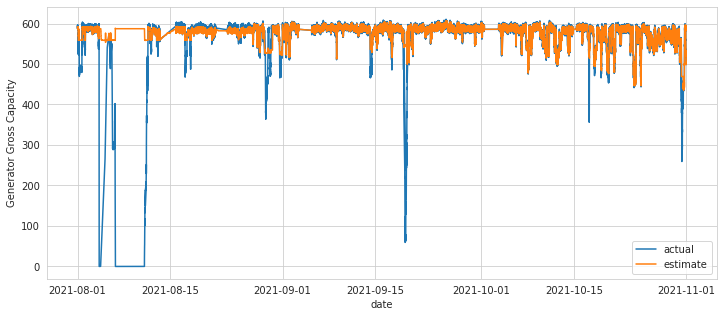

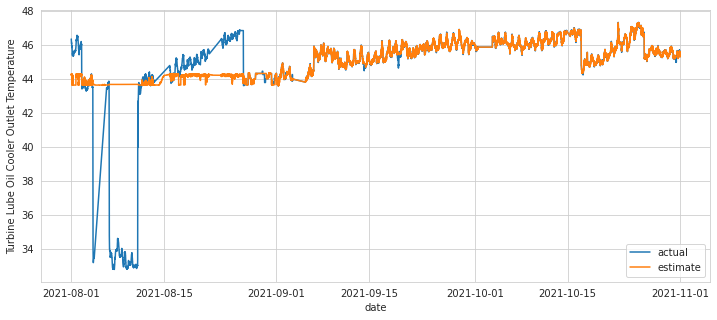

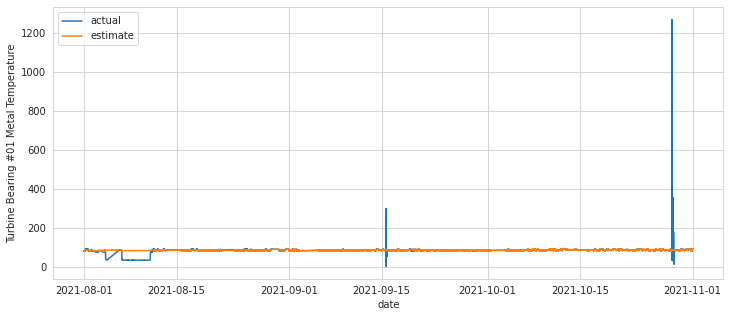

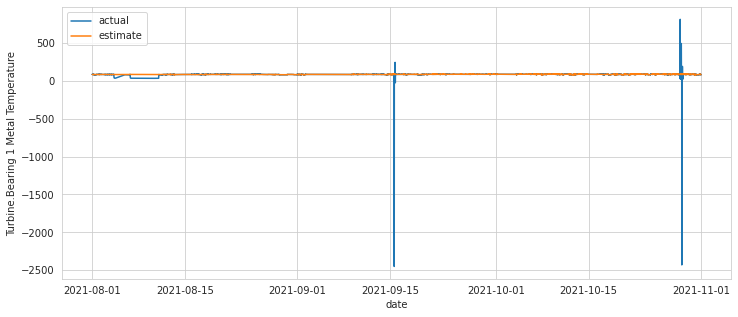

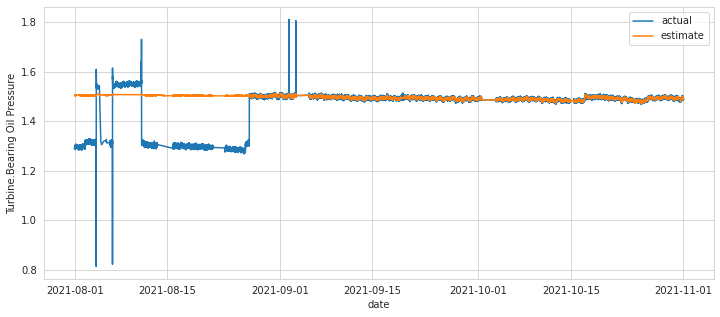

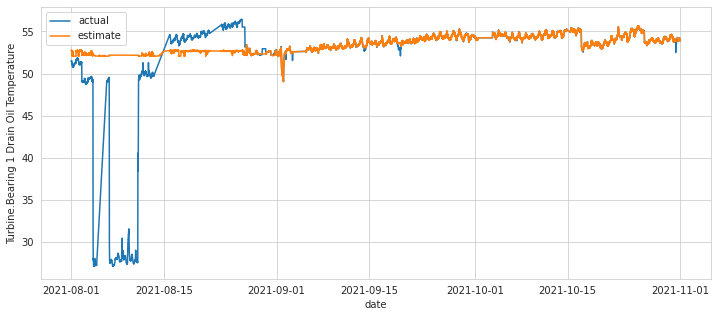

In [ ]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

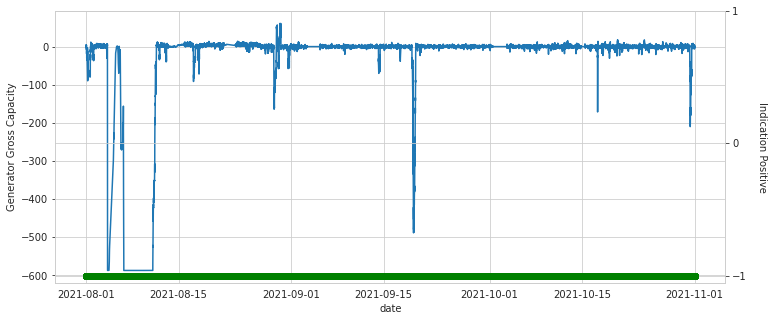

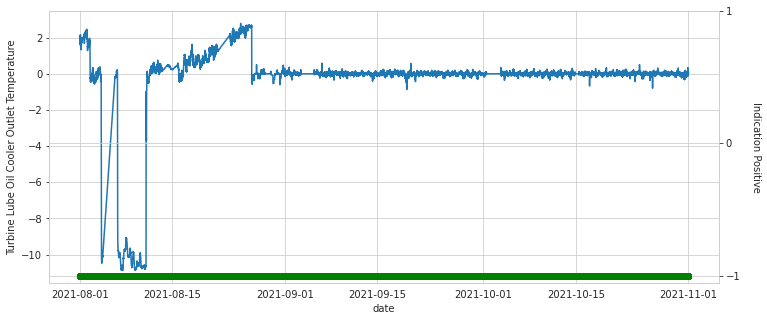

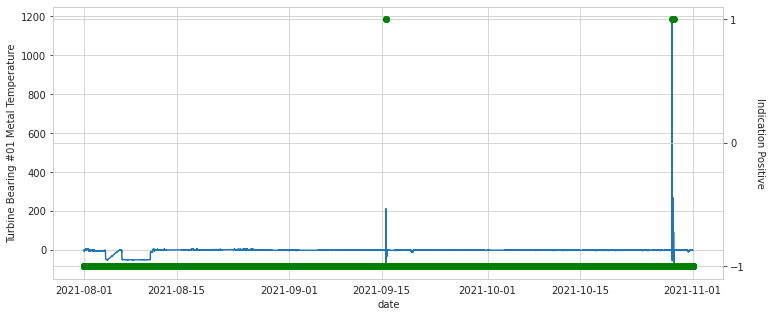

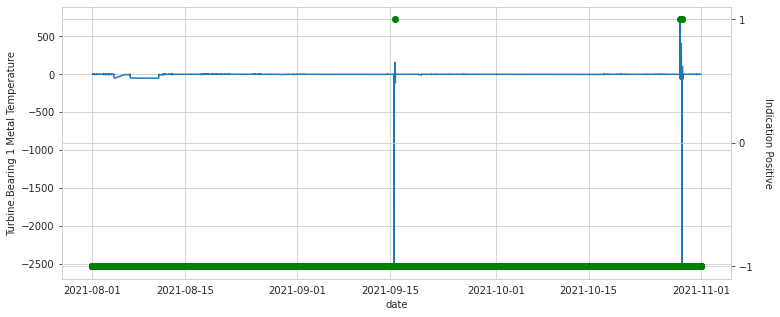

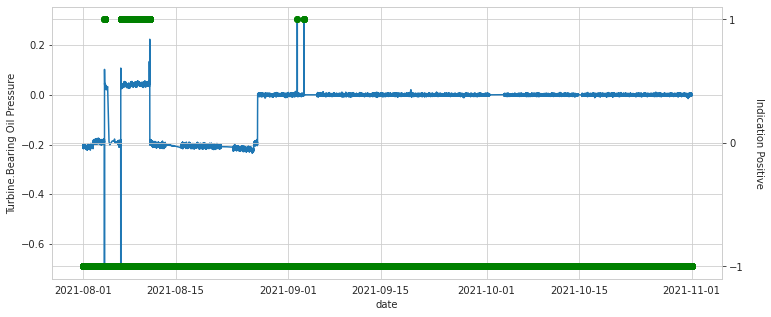

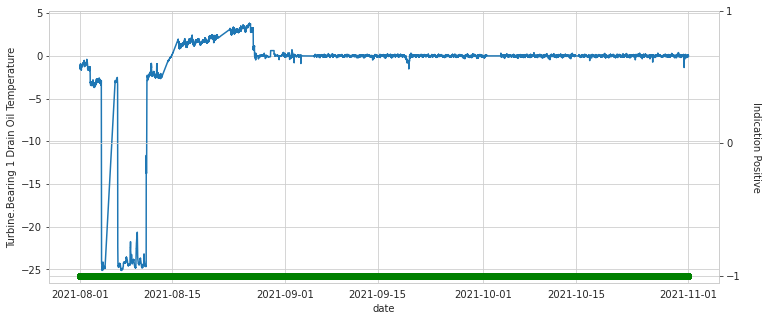

In [ ]:
# plot residual and residual indication positive
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(df_residual['date'], df_residual[col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax2.scatter(df_resid_ind_pos['date'], df_resid_ind_pos[col], color='green')
    ax2.set_ylabel('Indication Positive', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,2))

    plt.show();

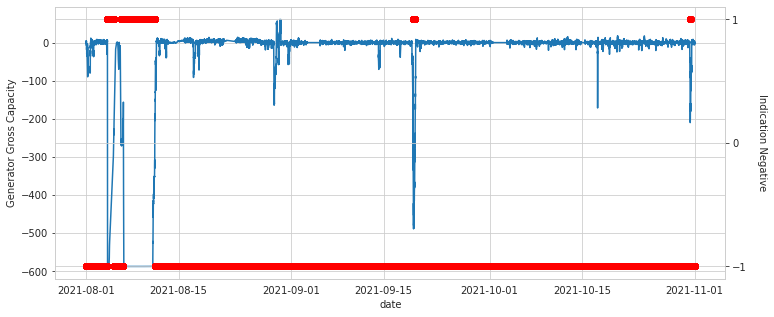

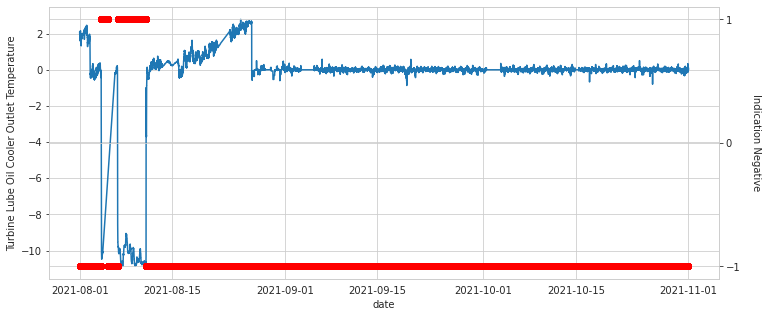

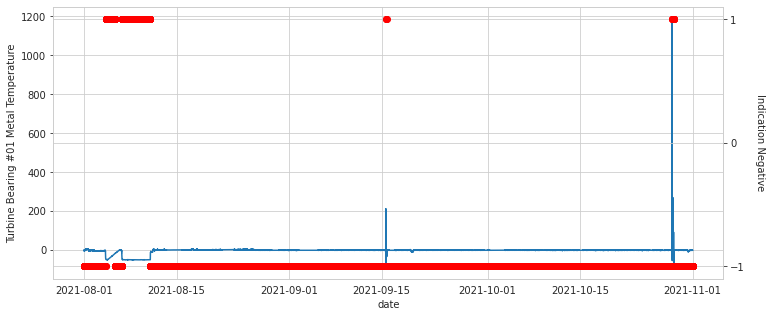

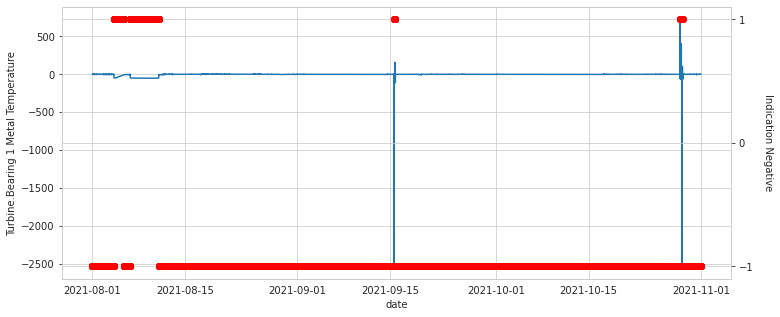

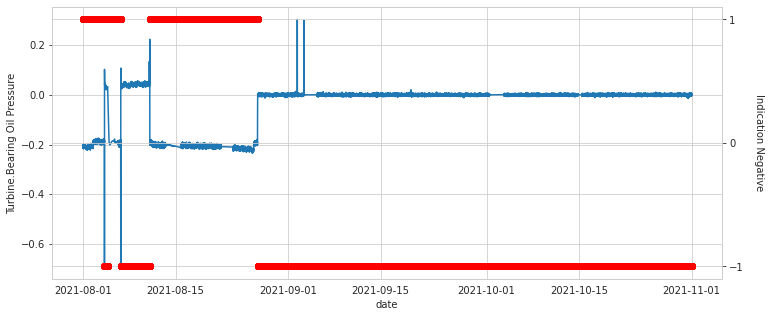

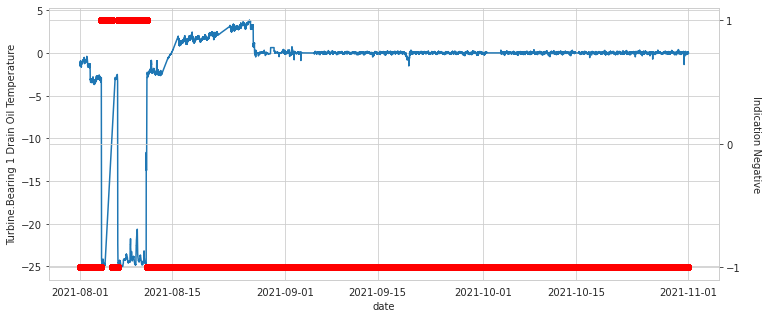

In [ ]:
# plot residual and residual indication negative
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(df_residual['date'], df_residual[col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax2.scatter(df_resid_ind_neg['date'], df_resid_ind_neg[col], color='red')
    ax2.set_ylabel('Indication Negative', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,2))

    plt.show();

## Rule Assignment

https://www.ge.com/digital/documentation/predix-apm/latest/r_apm_smartsignal_exp_syn_logical_functions.html

Function: `WindowRatio()`
- Description: This function looks at a window of data and compares it to a threshold. If the number of true comparisons is greater than or equal to the `trueSize` than `windowRatio` will return `true` otherwise it will return `false`.
    - Integer `trueSize`, The trueSize specifies the number of true comparison must be found in the window (specified in values) for windowRatio to return `True`. When a `NaN` present in values the `TrueSize` is divided by the window to create a ratio (or percentage) for which 
    - List values, A list of tag values to be compared to the threshold. The window size is specified by the size of the list. E.g. `Tag.Actual(20)` is a window of 20 
    - String comparisonOperator,  Specifies how to compare the values to the threshold. Valid options are: `=`, `>`, `<`, `>=`, `<=`, `!=`. The operator must be in quotes, `“=”`
    - Float threshold, A threshold that the values will be compared to
    - Integer requiredGoodSize, The required number of numeric values. If the number of numeric (non `NaN`s) in values is less than this value `windowRatio` will return `false`. Typically `requiredGoodSize` is about `one half the window size.`
- Example: `WindowRatio(17, Tag.ResidualIndicationPositive(18), ”=”, 1, 9)`

### High (H)

**Expressions:**

```
(WindowRatio(16, Tag.ResidualIndicationPositive(18), "=", 1, 9)) And 
(Tag.Residual >= Tag.ResidualPositiveThreshold)
```

### Very High (VH)

Expressions:
```
(WindowRatio(8, Tag.ResidualIndicationPositive(9), "=", 1, 6)) And 
(WindowRatio(6, Tag.Residual(9), ">=", (2.0* TagResidualPositiveThreshold), 6)) and
(Tag.Residual>=(2.0* Tag.ResidualPositiveThreshold))
```

### Step High (SH)

**Expressions:**
```
IsStep(Tag.Actual(7), 2.5* Tag.ResidualPositiveThreshold, NaN()) And
(Tag.Residual>(1.5* Tag.ResidualPositiveThreshold))
```

### Step Very High (SVH)

**Expressions:**
```
IsStep(Tag.Actual(7), 3.0*Tag.ResidualPositiveThreshold, NaN()) and 
(Tag.Residual > (2.0*Tag.ResidualPositiveThreshold)) and 
Tag.ResidualIndicationPositive=1
```

### Variance (VAR)

Expressions:
```
(Variance(Tag.Residual(18)) > (4*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)])^2))
And 
WindowRatio(2, Tag.Residual(6),"">="",Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
And 
WindowRatio(2,Tag.Residual(6),""<="",(-1)*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
```

## Model Diagnostic

**Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```